In [1]:
%matplotlib inline
import nibabel as nib
import numpy as np
from scipy import ndimage
from keras import backend as K
from sklearn.metrics import accuracy_score, precision_score

from utils import *
from model_FCNN import generate_model

seed = 47
np.random.seed(seed)

Using TensorFlow backend.


In [104]:
from importlib import reload

import utils
reload(utils)
from utils import *

import model_FCNN
reload(model_FCNN)
from model_FCNN import generate_model

# Problem configuration

In [146]:
num_classes = 11

n_training = 15
n_test = 5

patience = 5
model_filename = 'models/outrun_step_{}.h5'
csv_filename = 'log/outrun_step_{}.cvs'

nb_epoch = 40
validation_split = 0.25

class_mapper = {0:0, 2:1, 3:2, 4:3, 5:4, 6:5, 7:6, 8:7, 9:8, 10:9, 11:10}
class_mapper_inv = {0:0, 1:2, 2:3, 3:4, 4:5, 5:6, 6:7, 7:8, 8:9, 9:10, 10:11}

matrix_size = (160, 220, 48)

extraction_step = (3, 3, 3)
#extraction_step = (9, 9, 3)

segment_size = (27, 27, 21)
core_size = (9, 9, 3)

# Architecture

# 1. Initial segmentation

## 1.1 Read data

In [147]:
QSM_vols = np.empty(((n_training,) + matrix_size), dtype=precision_global)
label_vols = np.empty(((n_training,) + matrix_size), dtype=precision_global)
for case_idx in range(1, n_training+1) :
    QSM_vols[(case_idx - 1), :, :, :] = read_vol(case_idx, 'QSM')
    label_vols[(case_idx - 1), :, :, :] = read_vol(case_idx, 'label')

## 1.2 Pre-processing

In [148]:
## Intensity normalisation (zero mean and unit variance)
QSM_mean = 127.0
QSM_std = 128.0
QSM_vols = (QSM_vols - QSM_mean) / QSM_std

# Combine labels of BG and CSF
tmp = np.copy(label_vols)
for class_idx in class_mapper :
    label_vols[tmp == class_idx] = class_mapper[class_idx]
del tmp

In [69]:
label_vols.max()

10.0

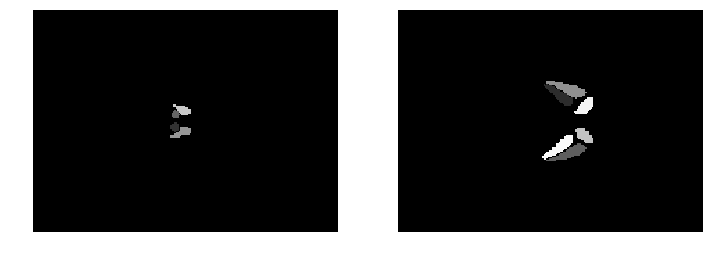

In [149]:
plots(50*np.squeeze(label_vols[0,:,:,[29,25]]))

## 1.3 Data preparation

In [150]:
#x_train, y_train = build_set(T1_vols, T2_vols, label_vols, (3, 9, 3))
x_train, y_train = build_set(QSM_vols, label_vols, extraction_step, segment_size, core_size)
x_train.shape, y_train.shape

((10095, 1, 27, 27, 21), (10095, 243, 11))

## 1.4 Configure callbacks

In [151]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

# Early stopping for reducing over-fitting risk
stopper = EarlyStopping(patience=patience)

# Model checkpoint to save the training results
checkpointer = ModelCheckpoint(
    filepath=model_filename.format('1'),
    verbose=0,
    save_best_only=True,
    save_weights_only=True)

# CSVLogger to save the training results in a csv file
csv_logger = CSVLogger(csv_filename.format(1), separator=';')

callbacks = [checkpointer, csv_logger, stopper]
#callbacks = [checkpointer, csv_logger]

## 1.5 Training

In [152]:
# Build model
model = generate_model(num_classes, segment_size, core_size)

K.set_value(model.optimizer.lr, 1e-3)

model.fit(
    x_train,
    y_train,
    epochs=nb_epoch,
    validation_split=validation_split,
    verbose=1,
    callbacks=callbacks)

# freeing space
#del x_train
#del y_train

Train on 7571 samples, validate on 2524 samples
Epoch 1/40
7571/7571 [==============================] - 51s - loss: 0.6796 - categorical_accuracy: 0.7993 - val_loss: 0.5257 - val_categorical_accuracy: 0.8380
Epoch 2/40
7571/7571 [==============================] - 48s - loss: 0.2680 - categorical_accuracy: 0.9085 - val_loss: 0.4130 - val_categorical_accuracy: 0.8928
Epoch 3/40
7571/7571 [==============================] - 49s - loss: 0.1230 - categorical_accuracy: 0.9507 - val_loss: 0.4134 - val_categorical_accuracy: 0.9024
Epoch 4/40
7571/7571 [==============================] - 49s - loss: 0.0816 - categorical_accuracy: 0.9665 - val_loss: 0.5078 - val_categorical_accuracy: 0.9000
Epoch 5/40
7571/7571 [==============================] - 49s - loss: 0.0554 - categorical_accuracy: 0.9774 - val_loss: 0.5675 - val_categorical_accuracy: 0.9001
Epoch 6/40
7571/7571 [==============================] - 49s - loss: 0.0392 - categorical_accuracy: 0.9844 - val_loss: 0.5176 - val_categorical_accuracy:

In [153]:
model.load_weights(model_filename.format('1'))

K.set_value(model.optimizer.lr, 1e-4)

model.fit(
    x_train,
    y_train,
    epochs=nb_epoch,
    validation_split=validation_split,
    verbose=1,
    callbacks=callbacks)

Train on 7571 samples, validate on 2524 samples
Epoch 1/40
7571/7571 [==============================] - 48s - loss: 0.1212 - categorical_accuracy: 0.9512 - val_loss: 0.4065 - val_categorical_accuracy: 0.9035
Epoch 2/40
7571/7571 [==============================] - 49s - loss: 0.0984 - categorical_accuracy: 0.9597 - val_loss: 0.4669 - val_categorical_accuracy: 0.9013
Epoch 3/40
7571/7571 [==============================] - 49s - loss: 0.0829 - categorical_accuracy: 0.9658 - val_loss: 0.4542 - val_categorical_accuracy: 0.9039
Epoch 4/40
7571/7571 [==============================] - 49s - loss: 0.0700 - categorical_accuracy: 0.9711 - val_loss: 0.5359 - val_categorical_accuracy: 0.9021
Epoch 5/40
7571/7571 [==============================] - 49s - loss: 0.0584 - categorical_accuracy: 0.9762 - val_loss: 0.5942 - val_categorical_accuracy: 0.9008
Epoch 6/40
7571/7571 [==============================] - 49s - loss: 0.0487 - categorical_accuracy: 0.9804 - val_loss: 0.6024 - val_categorical_accuracy:

In [ ]:
model.load_weights(model_filename.format('1'))

K.set_value(model.optimizer.lr, 1e-5)

model.fit(
    x_train,
    y_train,
    epochs=20,
    validation_split=validation_split,
    verbose=1,
    callbacks=callbacks)

In [ ]:
model.save_weights(model_filename.format(1))

## 1.6 Classification

In [154]:
from keras.models import load_model

# Load best model
model = generate_model(num_classes, segment_size, core_size)
model.load_weights(model_filename.format(1))

In [155]:
len_patch = extract_patches(read_vol(1, 'QSM'), patch_shape=segment_size, extraction_step=(9, 9, 3)).shape[0]
len_patch

3300

In [156]:
segmentations_all = []

for case_idx in range(1,16):

    print(case_idx)
    QSM_test_vol = read_vol(case_idx, 'QSM')

    x_test = np.zeros((len_patch, 1,) + segment_size, dtype=precision_global)
    x_test[:, 0, :, :, :] = extract_patches(QSM_test_vol, patch_shape=segment_size, extraction_step=(9, 9, 3))
    x_test[:, 0, :, :, :] = (x_test[:, 0, :, :, :] - QSM_mean) / QSM_std

    pred = model.predict(x_test, verbose=1)
    pred_classes = np.argmax(pred, axis=2)
    pred_classes = pred_classes.reshape((len(pred_classes), 9, 9, 3))
    segmentation = reconstruct_volume(pred_classes, matrix_size)
    
    segmentations_all = segmentations_all + [segmentation]
    
segmentations_all = np.stack(segmentations_all, axis=0)

1
3296/3300 [============================>.] - ETA: 0s

In [157]:
#segmentation = reconstruct_volume(pred_classes, matrix_size)
segmentations_all.max()

10.0

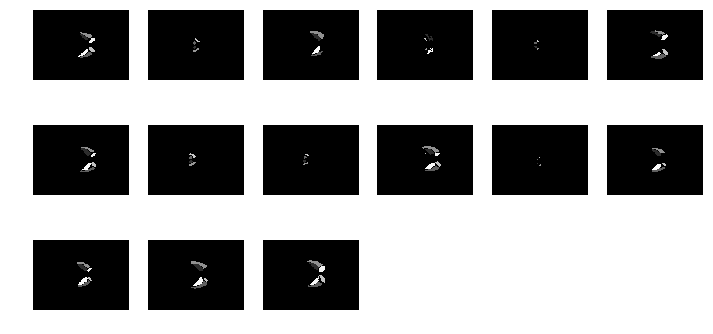

In [158]:
plots(50*(np.squeeze(label_vols[0:15,:,:,25])), rows=3)

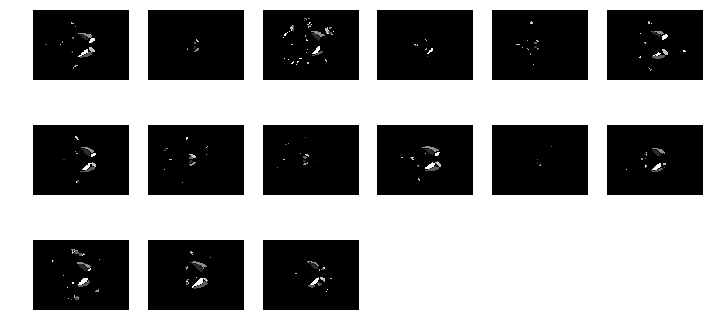

In [159]:
plots(50*(np.squeeze(segmentations_all[0:15,:,:,25])), rows=3)

In [ ]:
for case_idx in range(1, 11) :
    QSM_test_vol = read_vol(case_idx, 'QSM')
    
    x_test = np.zeros((len_patch, 1, 27, 27, 27), dtype=precision_global)
    x_test[:, 0, :, :, :] = extract_patches(QSM_test_vol, patch_shape=(27, 27, 27), extraction_step=(3, 3, 3))
    x_test[:, 0, :, :, :] = (x_test[:, 0, :, :, :] - QSM_mean) / QSM_std

    pred = model.predict(x_test, verbose=2)
    pred_classes = np.argmax(pred, axis=2)
    pred_classes = pred_classes.reshape((len(pred_classes), 9, 9, 9))
    segmentation = reconstruct_volume(pred_classes, matrix_size)
    
    segmentation[segmentation == 1] = 1
    segmentation[segmentation == 0] = 0
    
    save_vol(segmentation, case_idx)
    
    print("Finished segmentation of case # {}".format(case_idx))

print("Done with Step 1")

# 2. Mask Refinement

## 2.1 Include more segment into training

In [160]:
from keras.models import load_model

# Load best model
model = generate_model(num_classes, segment_size, core_size)
model.load_weights(model_filename.format('1'))

In [161]:
len_patch = extract_patches(read_vol(1, 'QSM'), patch_shape=segment_size, extraction_step=(9, 9, 3)).shape[0]
len_patch

3300

In [162]:
segmentations_all = []

for case_idx in range(1,16):

    print(case_idx)
    QSM_test_vol = read_vol(case_idx, 'QSM')

    x_test = np.zeros((len_patch, 1,) + segment_size, dtype=precision_global)
    x_test[:, 0, :, :, :] = extract_patches(QSM_test_vol, patch_shape=segment_size, extraction_step=(9, 9, 3))
    x_test[:, 0, :, :, :] = (x_test[:, 0, :, :, :] - QSM_mean) / QSM_std

    pred = model.predict(x_test, verbose=1)
    pred_classes = np.argmax(pred, axis=2)
    pred_classes = pred_classes.reshape((len(pred_classes), 9, 9, 3))
    segmentation = reconstruct_volume(pred_classes, matrix_size)
    
    segmentations_all = segmentations_all + [segmentation]
    
segmentations_all = np.stack(segmentations_all, axis=0)

1
3296/3300 [============================>.] - ETA: 0s

In [163]:
diff_vols = (label_vols == 0) & (segmentations_all != 0);

In [164]:
mask_vols = np.zeros(label_vols.shape, dtype=precision_global)
mask_vols[diff_vols == True] = 1

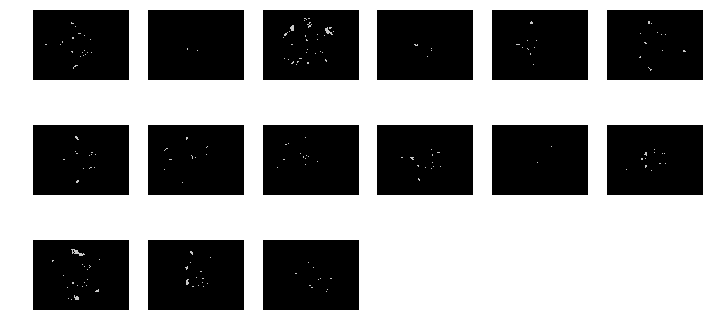

In [165]:
plots(200*(np.squeeze(mask_vols[0:15,:,:,25])), rows=3)

## 2.2 Rebuild training dataset

In [166]:
x_train, y_train = build_set_mask(QSM_vols, label_vols, extraction_step, mask_vols, segment_size, core_size)
x_train.shape, y_train.shape

((34209, 1, 27, 27, 21), (34209, 243, 11))

## 2.3 Regenerate model

In [167]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

# Early stopping for reducing over-fitting risk
stopper = EarlyStopping(patience=patience)

# Model checkpoint to save the training results
checkpointer = ModelCheckpoint(
    filepath=model_filename.format('2'),
    verbose=0,
    save_best_only=True,
    save_weights_only=True)

# CSVLogger to save the training results in a csv file
csv_logger = CSVLogger(csv_filename.format(1), separator=';')

callbacks = [checkpointer, csv_logger, stopper]
#callbacks = [checkpointer, csv_logger]

In [168]:
# Build model
model = generate_model(num_classes, segment_size, core_size)

# Load optimized weights
model.load_weights(model_filename.format('1'))

K.set_value(model.optimizer.lr, 1e-4)

# Start fine-tuning
model.fit(
    x_train,
    y_train,
    epochs=nb_epoch,
    validation_split=validation_split,
    verbose=1,
    callbacks=callbacks)

# freeing space
#del x_train
#del y_train

Train on 25656 samples, validate on 8553 samples
Epoch 1/40
25656/25656 [==============================] - 170s - loss: 0.0395 - categorical_accuracy: 0.9843 - val_loss: 0.1810 - val_categorical_accuracy: 0.9663
Epoch 2/40
25656/25656 [==============================] - 166s - loss: 0.0248 - categorical_accuracy: 0.9899 - val_loss: 0.1909 - val_categorical_accuracy: 0.9677
Epoch 3/40
25656/25656 [==============================] - 166s - loss: 0.0183 - categorical_accuracy: 0.9926 - val_loss: 0.2293 - val_categorical_accuracy: 0.9662
Epoch 4/40
25656/25656 [==============================] - 166s - loss: 0.0153 - categorical_accuracy: 0.9939 - val_loss: 0.2329 - val_categorical_accuracy: 0.9677
Epoch 5/40
25656/25656 [==============================] - 166s - loss: 0.0105 - categorical_accuracy: 0.9959 - val_loss: 0.2476 - val_categorical_accuracy: 0.9675
Epoch 6/40
25656/25656 [==============================] - 166s - loss: 0.0082 - categorical_accuracy: 0.9968 - val_loss: 0.2839 - val_ca

In [169]:
model.load_weights(model_filename.format('2'))

K.set_value(model.optimizer.lr, 1e-5)

# Start fine-tuning
model.fit(
    x_train,
    y_train,
    epochs=20,
    validation_split=validation_split,
    verbose=1,
    callbacks=callbacks)

Train on 25656 samples, validate on 8553 samples
Epoch 1/20
25656/25656 [==============================] - 166s - loss: 0.0260 - categorical_accuracy: 0.9895 - val_loss: 0.1828 - val_categorical_accuracy: 0.9674
Epoch 2/20
25656/25656 [==============================] - 166s - loss: 0.0244 - categorical_accuracy: 0.9901 - val_loss: 0.1846 - val_categorical_accuracy: 0.9672
Epoch 3/20
25656/25656 [==============================] - 166s - loss: 0.0231 - categorical_accuracy: 0.9906 - val_loss: 0.1925 - val_categorical_accuracy: 0.9672
Epoch 4/20
25656/25656 [==============================] - 166s - loss: 0.0219 - categorical_accuracy: 0.9911 - val_loss: 0.1944 - val_categorical_accuracy: 0.9673
Epoch 5/20
25656/25656 [==============================] - 166s - loss: 0.0208 - categorical_accuracy: 0.9916 - val_loss: 0.2043 - val_categorical_accuracy: 0.9671
Epoch 6/20
25656/25656 [==============================] - 166s - loss: 0.0196 - categorical_accuracy: 0.9921 - val_loss: 0.2086 - val_ca

In [ ]:
model.save_weights(model_filename.format('2'))

In [170]:
# Load best model
model = generate_model(num_classes, segment_size, core_size)
model.load_weights(model_filename.format('2'))

In [171]:
segmentations2_all = []

for case_idx in range(1,16):
    
    print(case_idx)
    QSM_test_vol = read_vol(case_idx, 'QSM')

    x_test = np.zeros((len_patch, 1,) + segment_size, dtype=precision_global)
    x_test[:, 0, :, :, :] = extract_patches(QSM_test_vol, patch_shape=segment_size, extraction_step=(9, 9, 3))
    x_test[:, 0, :, :, :] = (x_test[:, 0, :, :, :] - QSM_mean) / QSM_std

    pred = model.predict(x_test, verbose=1)
    pred_classes = np.argmax(pred, axis=2)
    pred_classes = pred_classes.reshape((len(pred_classes), 9, 9, 3))
    segmentation = reconstruct_volume(pred_classes, matrix_size)
    
    segmentations2_all = segmentations2_all + [segmentation]
    
segmentations2_all = np.stack(segmentations2_all, axis=0)


1
3296/3300 [============================>.] - ETA: 0s

In [172]:
segmentations2_all.max()

10.0

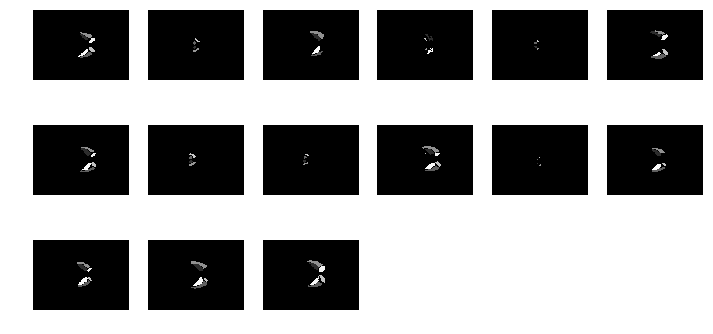

In [173]:
plots(50*(np.squeeze(label_vols[0:15,:,:,25])), rows=3)

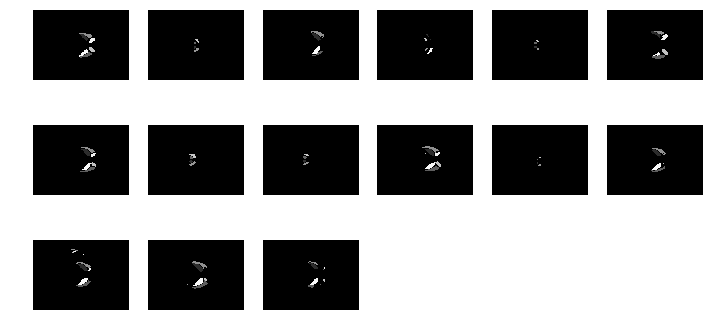

In [174]:
plots(50*(np.squeeze(segmentations2_all[0:15,:,:,25])), rows=3)

In [205]:
segmentations2_all = []

for case_idx in range(16,21):
    
    print(case_idx)
    QSM_test_vol = read_vol(case_idx, 'QSM')

    x_test = np.zeros((len_patch, 1,) + segment_size, dtype=precision_global)
    x_test[:, 0, :, :, :] = extract_patches(QSM_test_vol, patch_shape=segment_size, extraction_step=(9, 9, 3))
    x_test[:, 0, :, :, :] = (x_test[:, 0, :, :, :] - QSM_mean) / QSM_std

    pred = model.predict(x_test, verbose=1)
    pred_classes = np.argmax(pred, axis=2)
    pred_classes = pred_classes.reshape((len(pred_classes), 9, 9, 3))
    segmentation = reconstruct_volume(pred_classes, matrix_size)
    
    segmentations2_all = segmentations2_all + [segmentation]
    
    tmp = np.copy(segmentation)
    for class_idx in class_mapper_inv :
        segmentation[tmp == class_idx] = class_mapper_inv[class_idx]
    del tmp
    
    save_vol(segmentation, case_idx)
    
segmentations2_all = np.stack(segmentations2_all, axis=0)

print("Done with Step 2")

16
3296/3300 [============================>.] - ETA: 0sDone with Step 2


# 3 Post-processing

## 3.1 Pick the largest connected component for each class

In [206]:
for case_idx in range(5):
    segmentation = np.squeeze(segmentations2_all[case_idx,:,:,:]);
    tmp = np.zeros(segmentation.shape, dtype=segmentation.dtype)
    
    for class_idx in class_mapper :
        mask = (segmentation == class_idx)
        
        if class_idx != 0 and mask.sum() > 0:
            labeled_mask, num_cc = ndimage.label(mask)
            largest_cc_mask = (labeled_mask == (np.bincount(labeled_mask.flat)[1:].argmax() + 1))
            
            tmp[largest_cc_mask == 1] = class_idx
        
    segmentations2_all[case_idx,:,:,:] = tmp

## 3.2 Save it 

In [207]:
for i_idx, case_idx in enumerate(range(16,21)):
    print(case_idx)
    
    segmentation = np.squeeze(segmentations2_all[i_idx,:,:,:]);

    save_vol(segmentation, case_idx)    

print("Done with Step 3")

16
17
18
19
20
Done with Step 3


## 3.3 Calculate metric 

In [210]:
QSM_vols = np.empty(((n_test,) + matrix_size), dtype=precision_global)
label_vols = np.empty(((n_test,) + matrix_size), dtype=precision_global)
for i_idx, case_idx in enumerate(range(16, 21)) :
    QSM_vols[i_idx, :, :, :] = read_vol(case_idx, 'QSM')
    label_vols[i_idx, :, :, :] = read_vol(case_idx, 'label')

In [248]:
def calc_dice(m1, m2):
    return 2*((m1==1) & (m2==1)).sum()/((m1==1).sum() + (m2==1).sum())

In [241]:
for i_idx, case_idx in enumerate(range(16, 21)) :
    print(case_idx, end='\t')
    print('{:.4f}'.format(accuracy_score(label_vols[i_idx,:,:,:].flat, segmentations2_all[i_idx,:,:,:].flat)), end='\t')
    for class_idx in class_mapper :
        mask = (np.squeeze(segmentations2_all[i_idx,:,:,:]) == class_idx)
        if class_idx != 0 and mask.sum() > 0:
            print('{:.4f}'.format(precision_score(label_vols[i_idx,:,:,:][mask], segmentations2_all[i_idx,:,:,:][mask], average='micro')), end='\t')
        else:
            print('N/A', end='\t')
    print()

16	0.9986	N/A	0.8941	0.8810	0.7833	0.7475	0.8762	0.9444	0.9204	0.8651	1.0000	0.8077	
17	0.9991	N/A	0.8804	0.8906	0.7700	0.6761	0.6720	0.9619	0.8709	0.8585	0.9651	0.7385	
18	0.9988	N/A	N/A	1.0000	0.7417	0.8053	0.7530	0.7280	0.9379	0.7580	0.8014	0.8096	
19	0.9992	N/A	0.7143	0.9091	0.8224	0.8402	0.9523	0.9680	0.8498	0.8623	0.7890	0.7774	
20	0.9987	N/A	1.0000	0.7917	0.7910	0.8587	0.9181	0.9352	0.6459	0.6202	0.8647	0.8018	


In [249]:
for i_idx, case_idx in enumerate(range(16, 21)) :
    print(case_idx, end='\t')
    for class_idx in class_mapper :
        mask = (np.squeeze(segmentations2_all[i_idx,:,:,:]) == class_idx)
        if class_idx != 0 and mask.sum() > 0:
            print('{:.4f}'.format(calc_dice((label_vols[i_idx,:,:,:]==class_idx).flat, (segmentations2_all[i_idx,:,:,:]==class_idx).flat)), end='\t')
        else:
            print(0, end='\t')
    print()

16	0	0.8736	0.8457	0.8641	0.8087	0.8870	0.9270	0.7112	0.8344	0.0894	0.1988	
17	0	0.8710	0.7451	0.8485	0.7956	0.7843	0.9039	0.8550	0.8809	0.7464	0.7825	
18	0	0	0.0690	0.8058	0.6190	0.7966	0.8058	0.3901	0.6451	0.6923	0.7823	
19	0	0.1724	0.6250	0.8421	0.8214	0.8947	0.8864	0.7668	0.8424	0.6703	0.7312	
20	0	0.9217	0.7550	0.8025	0.8757	0.7578	0.7653	0.5825	0.6676	0.6806	0.6634	
